# Analyzing Startup Fundraising Deals from Crunchbase

We will analyze startup investments from Crunchbase.com.

Every year, thousands of startup companies raise financing from investors. Each time a startup raises money, we refer to the event as a fundraising round. Crunchbase is a website that crowdsources information on the fundraising rounds of many startups. The Crunchbase user community submits, edits, and maintains most of the information in Crunchbase.

In return, Crunchbase makes the data available through a Web application and a fee-based API. Before Crunchbase switched to the paid API model, multiple groups crawled the site and released the data online. Because the information on the startups and their fundraising rounds is always changing, the data set we'll be using isn't completely up to date.

The data set of investments we'll be exploring is current as of October 2013. You can download it from [GitHub].

Throughout this guided project, we'll practice working with different memory constraints. In this step, let's assume we only have 10 megabytes of available memory. While `crunchbase-investments.csv` consumes 10.3 megabytes of disk space, we know from earlier missions that pandas often requires 4 to 6 times amount of space in memory as the file does on disk (especially when there's many string columns).

[Crunchbase]: https://www.crunchbase.com/
[Github]: https://github.com/datahoarder/crunchbase-october-2013/blob/master/crunchbase-investments.csv

In [1]:
import sqlite3
import pandas as pd
import pprint as pp
import matplotlib.pyplot as plt
pd.options.display.max_columns = 99

In [2]:
!ls

crunchbase.db
crunchbase-investments.csv
project03_analyzing_startup_fundraising_deals_from_crunchbase.ipynb


## Introduction

- Because the data set contains over 50,000 rows, you'll need to read the data set into dataframes using 5,000 row chunks to ensure that each chunk consumes much less than 10 megabytes of memory.
- Across all of the chunks, become familiar with:
    - Each column's missing value counts
    - Each column's memory footprint
    - The total memory footprint of all of the chunks combined
    - Which column(s) we can drop because they aren't useful for analysis

### Check Chunk's Memory

Chunk 1 memory: 5.58 mb
Chunk 2 memory: 5.53 mb
Chunk 3 memory: 5.54 mb
Chunk 4 memory: 5.53 mb
Chunk 5 memory: 5.52 mb
Chunk 6 memory: 5.55 mb
Chunk 7 memory: 5.53 mb
Chunk 8 memory: 5.51 mb
Chunk 9 memory: 5.40 mb
Chunk 10 memory: 4.64 mb
Chunk 11 memory: 2.66 mb


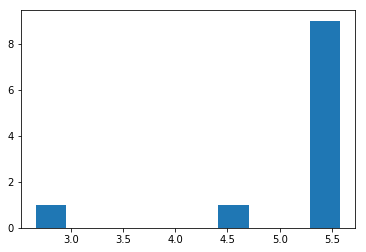

In [3]:
chunks_it = pd.read_csv('crunchbase-investments.csv', chunksize=5000, 
                        encoding='ISO-8859-1')

memory_footprints = []
i = 0

for chunk in chunks_it:
    i += 1
    chunk_memory_mb = chunk.memory_usage(deep=True).sum() / 1048576
    memory_footprints.append(chunk_memory_mb)
    print("Chunk {0} memory: {1:0.2f} mb".format(i, chunk_memory_mb))

plt.hist(memory_footprints)
plt.show()

**Observations**:

- Each chunk is under the 10 MB of memory requirement we had set
- Each chunk has ~5.5 MB except the last 2 chunks

### Check each column's missing value counts across all chunks

In [4]:
chunks_it = pd.read_csv('crunchbase-investments.csv', chunksize=5000, 
                        encoding='ISO-8859-1')

missing_vc_list = []
i = 0

for chunk in chunks_it:
    i += 1
    #print("Chunk {0}:".format(i))
    result = chunk.isnull().sum()
    #print(type(result))
    missing_vc_list.append(result)

combined_missing_vc = pd.concat(missing_vc_list)
unique_combined_missing_vc = combined_missing_vc.groupby(combined_missing_vc.index).sum()

unique_combined_missing_vc.sort_values()

company_country_code          1
company_name                  1
company_permalink             1
company_region                1
investor_region               2
investor_permalink            2
investor_name                 2
funded_quarter                3
funded_at                     3
funded_month                  3
funded_year                   3
funding_round_type            3
company_state_code          492
company_city                533
company_category_code       643
raised_amount_usd          3599
investor_country_code     12001
investor_city             12480
investor_state_code       16809
investor_category_code    50427
dtype: int64

**Observations**:

- There is a lot of investor related information missing across the dataset, specifically investor state code, investor category code, investor city and investory country code

### Check each column's memory footprint

In [5]:
chunks_it = pd.read_csv('crunchbase-investments.csv', chunksize=5000, 
                        encoding='ISO-8859-1')

series_memory_fp = pd.Series()
counter = 0

for chunk in chunks_it:
    if counter == 0:
        series_memory_fp = chunk.memory_usage(deep=True)
    else:
        series_memory_fp += chunk.memory_usage(deep=True)
    counter += 1

series_memory_fp = series_memory_fp.drop('Index')
series_memory_fp

company_permalink         4057788
company_name              3591326
company_category_code     3421104
company_country_code      3172176
company_state_code        3106051
company_region            3411585
company_city              3505926
investor_permalink        4980548
investor_name             3915666
investor_category_code     622424
investor_country_code     2647292
investor_state_code       2476607
investor_region           3396281
investor_city             2885083
funding_round_type        3410707
funded_at                 3542185
funded_month              3383584
funded_quarter            3383584
funded_year                422960
raised_amount_usd          422960
dtype: int64

### The total memory footprint of all of the chunks combined

In [6]:
chunks_it = pd.read_csv('crunchbase-investments.csv', chunksize=5000, 
                        encoding='ISO-8859-1')

memory_footprints = []
i = 0

for chunk in chunks_it:
    i += 1
    chunk_memory_mb = chunk.memory_usage(deep=True).sum() / 1048576
    memory_footprints.append(chunk_memory_mb)
    print("Chunk {0} memory: {1:0.2f} mb".format(i, chunk_memory_mb))

print("Total memory: {0:0.2f} mb".format(sum(memory_footprints)))

Chunk 1 memory: 5.58 mb
Chunk 2 memory: 5.53 mb
Chunk 3 memory: 5.54 mb
Chunk 4 memory: 5.53 mb
Chunk 5 memory: 5.52 mb
Chunk 6 memory: 5.55 mb
Chunk 7 memory: 5.53 mb
Chunk 8 memory: 5.51 mb
Chunk 9 memory: 5.40 mb
Chunk 10 memory: 4.64 mb
Chunk 11 memory: 2.66 mb
Total memory: 56.99 mb


In [7]:
series_memory_fp.sum() / (1048576)

56.9876070022583

### Which column(s) we can drop because they aren't useful for analysis

Let's drop columns that aren't very helpful (URLs) or columns that have too many missing columns (`> 90%`)

In [8]:
chunks_it = pd.read_csv('crunchbase-investments.csv', chunksize=5000, 
                        encoding='ISO-8859-1')
total_num_rows = 0
for chunk in chunks_it:
    total_num_rows += chunk.shape[0]

print("Total Rows: {0}".format(total_num_rows))

Total Rows: 52870


In [9]:
# get percentage of missing values per column
unique_combined_missing_vc.sort_values() / total_num_rows * 100

company_country_code       0.001891
company_name               0.001891
company_permalink          0.001891
company_region             0.001891
investor_region            0.003783
investor_permalink         0.003783
investor_name              0.003783
funded_quarter             0.005674
funded_at                  0.005674
funded_month               0.005674
funded_year                0.005674
funding_round_type         0.005674
company_state_code         0.930584
company_city               1.008133
company_category_code      1.216191
raised_amount_usd          6.807263
investor_country_code     22.699073
investor_city             23.605069
investor_state_code       31.793077
investor_category_code    95.379232
dtype: float64

In [12]:
# Drop columns representing URLs or containing too many missing values ( > 90%)
drop_cols = ['investor_permalink', 'company_permalink', 'investor_category_code']
keep_cols = chunk.columns.drop(drop_cols)

print('Columns to Keep:')
print(keep_cols.tolist())

Columns to Keep:
['company_name', 'company_category_code', 'company_country_code', 'company_state_code', 'company_region', 'company_city', 'investor_name', 'investor_country_code', 'investor_state_code', 'investor_region', 'investor_city', 'funding_round_type', 'funded_at', 'funded_month', 'funded_quarter', 'funded_year', 'raised_amount_usd']


---

## Selecting Data Types

Let's get familiar with the column types before adding the data into SQLite.

- Identify the types for each column.
- Identify the numeric columns we can represent using more space efficient types.
- For text columns:
    - Analyze the unique value counts across all of the chunks to see if we can convert them to a numeric type.
    - See if we clean clean any text columns and separate them into multiple numeric columns without adding any overhead when querying.
- Make your changes to the code from the last step so that the overall memory the data consumes stays under 10 megabytes.

### Types for each column

In [13]:
chunks_it = pd.read_csv('crunchbase-investments.csv', chunksize=5000, 
                        encoding='ISO-8859-1', usecols=keep_cols)
col_types = {}
i = 0
for chunk in chunks_it:
    i += 1
    #print("Chunk {0}:".format(i))
    #print(chunk.dtypes)
    for col in chunk.columns:
        if col not in col_types:
            # use a set to keep only unique values!
            col_types[col] = set([str(chunk.dtypes[col])])
        else:
            col_types[col].add(str(chunk.dtypes[col]))
        
        #print('\t', col, '|', col_types[col])
    #break

pp.pprint(col_types)

{'company_category_code': {'object'},
 'company_city': {'object'},
 'company_country_code': {'object'},
 'company_name': {'object'},
 'company_region': {'object'},
 'company_state_code': {'object'},
 'funded_at': {'object'},
 'funded_month': {'object'},
 'funded_quarter': {'object'},
 'funded_year': {'int64', 'float64'},
 'funding_round_type': {'object'},
 'investor_city': {'object', 'float64'},
 'investor_country_code': {'object', 'float64'},
 'investor_name': {'object'},
 'investor_region': {'object'},
 'investor_state_code': {'object', 'float64'},
 'raised_amount_usd': {'float64'}}


**Observations**:

- A few columns have several types: `funded_year`, `investor_city`, `investor_country_code`, `investor_state_code`
- There are a number of **object** type columns which could be converted to more appropriate, space efficient data types

### Identify the numeric columns we can represent using more space efficient types

In [14]:
chunks_it = pd.read_csv('crunchbase-investments.csv', chunksize=5000, 
                        encoding='ISO-8859-1', usecols=keep_cols)
count = 0

for chunk in chunks_it:
    count += 1
    print(f'\nChunk {count:<3}:', end=' ')
    float_cols = chunk.select_dtypes(include=['float', 'int']).columns
    print(float_cols)
    
    chunk['raised_amount_usd'] = pd.to_numeric(chunk['raised_amount_usd'],
                                               downcast='float')


Chunk 1  : Index(['funded_year', 'raised_amount_usd'], dtype='object')

Chunk 2  : Index(['funded_year', 'raised_amount_usd'], dtype='object')

Chunk 3  : Index(['funded_year', 'raised_amount_usd'], dtype='object')

Chunk 4  : Index(['funded_year', 'raised_amount_usd'], dtype='object')

Chunk 5  : Index(['funded_year', 'raised_amount_usd'], dtype='object')

Chunk 6  : Index(['funded_year', 'raised_amount_usd'], dtype='object')

Chunk 7  : Index(['funded_year', 'raised_amount_usd'], dtype='object')

Chunk 8  : Index(['funded_year', 'raised_amount_usd'], dtype='object')

Chunk 9  : Index(['funded_year', 'raised_amount_usd'], dtype='object')

Chunk 10 : Index(['investor_country_code', 'investor_state_code', 'investor_city',
       'funded_year', 'raised_amount_usd'],
      dtype='object')

Chunk 11 : Index(['investor_country_code', 'investor_state_code', 'investor_city',
       'funded_year', 'raised_amount_usd'],
      dtype='object')


**Observations**:

- The `raised_amount_usd` is the only consistent float column across all the chunks. We could use a more space efficient type for it.

Let's dig a little deeper and look at the unique values within the numeric columns.

In [15]:
chunks_it = pd.read_csv('crunchbase-investments.csv', chunksize=5000, 
                        encoding='ISO-8859-1', usecols=keep_cols)
count = 0
str_cols_vc = {}

for chunk in chunks_it:
    count += 1
    print(f'\nCHUNK {count}:')
    
    num_cols = chunk.select_dtypes(include=['float', 'int'])
    for col in num_cols:
        print(f'\n{col}')
        current_col_vc = num_cols[col].value_counts()
        #continue
        
        if col in str_cols_vc:
            str_cols_vc[col].append(current_col_vc)
        else:
            str_cols_vc[col] = [current_col_vc]
        
        
        unique_values = chunk[col].unique()
        print(f'type: {chunk[col].dtype} | {len(unique_values)} values: {unique_values[:5]}')
        
    #break

## Combine the value count results
combined_vcs = {}

for col, vc_list in str_cols_vc.items():
    combined_vc = pd.concat(vc_list)
    final_vc = combined_vc.groupby(combined_vc.index).sum()
    combined_vcs[col] = final_vc

#pp.pprint(combined_vcs)


CHUNK 1:

funded_year
type: int64 | 18 values: [2012 2011 2010 2009 2007]

raised_amount_usd
type: float64 | 625 values: [2000000.   20000.   70000.   75000.  100000.]

CHUNK 2:

funded_year
type: int64 | 17 values: [2008 2009 2007 2010 2006]

raised_amount_usd
type: float64 | 613 values: [25000000. 20000000. 26000000. 34500000. 68000000.]

CHUNK 3:

funded_year
type: int64 | 17 values: [2009 2007 2011 2012 2010]

raised_amount_usd
type: float64 | 634 values: [37400000.  6000000. 22300000.  8387128. 15700000.]

CHUNK 4:

funded_year
type: int64 | 15 values: [2011 2012 2013 2010 2005]

raised_amount_usd
type: float64 | 588 values: [ 3000000.  5000000. 85000000. 15000000.  5300000.]

CHUNK 5:

funded_year
type: int64 | 19 values: [2010 2007 2008 2011 2012]

raised_amount_usd
type: float64 | 627 values: [15000000. 14900000.   935000.   365000.  1300000.]

CHUNK 6:

funded_year
type: int64 | 15 values: [2009 2010 2006 2005 2011]

raised_amount_usd
type: float64 | 612 values: [29000000.  2

**Observations**:

- The `funded_year` column can be converted from float to integer as it shows the funded year
- There are only 2 numeric columns - `funded_year` and `raised_amount_usd`. The remaining columns are showing up because they have Nan values in the later chunks.
- The `raised_amount_usd` column can be downcast as a float to a more space efficient type.
- Addition: The `funded_at` column has the necessary year, month, day info - so the `funded_year` is no longer required!

### Text Columns

- Analyze the unique value counts across all of the chunks to see if we can convert them to a numeric type.
- See if we clean clean any text columns and separate them into multiple numeric columns without adding any overhead when querying.

In [16]:
chunks_it = pd.read_csv('crunchbase-investments.csv', chunksize=5000, 
                        encoding='ISO-8859-1', usecols=keep_cols)
count = 0
#total_num_rows = 0
str_cols_vc = {}

for chunk in chunks_it:
    count += 1
    #total_num_rows += chunk.shape[0]
    
    print(f'\nCHUNK {count}:')
    #print(chunk.dtypes.value_counts())
    
    obj_cols = chunk.select_dtypes(include=['object'])
    #print(obj_cols.value_counts())
    #print(type(obj_cols))
    for col in obj_cols:
        current_col_vc = obj_cols[col].value_counts()
        
        if col in str_cols_vc:
            str_cols_vc[col].append(current_col_vc)
        else:
            str_cols_vc[col] = [current_col_vc]
        
        unique_values = chunk[col].unique()
        print(f'col: {col} | type: {chunk[col].dtype} |'\
              f' {len(unique_values)} values: {unique_values[:5]}')

#print(f'Total Num Rows: {total_num_rows}')

## Combine the value count results
combined_vcs = {}

for col, vc_list in str_cols_vc.items():
    combined_vc = pd.concat(vc_list)
    final_vc = combined_vc.groupby(combined_vc.index).sum()
    combined_vcs[col] = final_vc

#pp.pprint(combined_vcs)


CHUNK 1:
col: company_name | type: object | 3373 values: ['AdverCar' 'LaunchGram' 'uTaP' 'ZoopShop' 'eFuneral']
col: company_category_code | type: object | 43 values: ['advertising' 'news' 'messaging' 'software' 'web']
col: company_country_code | type: object | 1 values: ['USA']
col: company_state_code | type: object | 48 values: ['CA' nan 'OH' 'NY' 'FL']
col: company_region | type: object | 215 values: ['SF Bay' 'United States - Other' 'Columbus' 'Cleveland' 'New York']
col: company_city | type: object | 543 values: ['San Francisco' 'Mountain View' nan 'columbus' 'Cleveland']
col: investor_name | type: object | 1540 values: ['1-800-FLOWERS.COM' '10Xelerator'
 '2010 NYU Stern Business Plan Competition' '22Hundred Group' '3taps']
col: investor_country_code | type: object | 46 values: ['USA' nan 'BMU' 'CHE' 'CAN']
col: investor_state_code | type: object | 44 values: ['NY' 'OH' nan 'CA' 'MA']
col: investor_region | type: object | 236 values: ['New York' 'Columbus' 'unknown' 'SF Bay' 'Bos


CHUNK 7:
col: company_name | type: object | 2987 values: ['Tricycle' 'Adapx' 'Action Engine' 'Vigilos' 'SprayCool']
col: company_category_code | type: object | 42 values: [nan 'software' 'mobile' 'hardware' 'public_relations']
col: company_country_code | type: object | 3 values: ['USA' nan '2008-02']
col: company_state_code | type: object | 49 values: ['TN' 'WA' 'OR' 'NV' 'CA']
col: company_region | type: object | 208 values: ['Chattanooga' 'Seattle' 'Liberty Lake' 'Portland' 'Spokane Valley']
col: company_city | type: object | 530 values: ['Chattanooga' 'Seattle' 'Bellevue' 'Liberty Lake' 'Beaverton']
col: investor_name | type: object | 688 values: ['Northwest Georgia Bank' 'Northwest Technology Ventures'
 'Northwest Venture Associates' 'Northwestern Capital' 'Northzone']
col: investor_country_code | type: object | 36 values: ['USA' nan 'SWE' 'GBR' 'CAN']
col: investor_state_code | type: object | 37 values: ['GA' 'OR' 'WA' nan 'MN']
col: investor_region | type: object | 156 values: [

In [17]:
chunks_it = pd.read_csv('crunchbase-investments.csv', chunksize=5000, 
                        encoding='ISO-8859-1', usecols=keep_cols)
count = 0
#total_num_rows = 0
str_cols_vc = {}

for chunk in chunks_it:
    count += 1
    #total_num_rows += chunk.shape[0]
    
    #print(f'\nChunk {count}:')
    #print(chunk.dtypes.value_counts())
    
    #obj_cols = chunk.select_dtypes(include=['object'])
    #print(obj_cols.value_counts())
    #print(type(obj_cols))
    #columns = ['investor_city', 'investor_country_code',
    #          'investor_state_code']
    for col in chunk:
        current_col_vc = chunk[col].value_counts()
        
        if col in str_cols_vc:
            str_cols_vc[col].append(current_col_vc)
        else:
            str_cols_vc[col] = [current_col_vc]

#print(f'Total Num Rows: {total_num_rows}')

## Combine the value count results
combined_vcs = {}

for col, vc_list in str_cols_vc.items():
    combined_vc = pd.concat(vc_list)
    final_vc = combined_vc.groupby(combined_vc.index).sum()
    combined_vcs[col] = final_vc

pp.pprint(combined_vcs.keys())

print('\nAll Value Counts:')
pp.pprint(combined_vcs)

dict_keys(['company_name', 'company_category_code', 'company_country_code', 'company_state_code', 'company_region', 'company_city', 'investor_name', 'investor_country_code', 'investor_state_code', 'investor_region', 'investor_city', 'funding_round_type', 'funded_at', 'funded_month', 'funded_quarter', 'funded_year', 'raised_amount_usd'])

All Value Counts:
{'company_category_code': 2/7/08                 1
advertising         3200
analytics           1863
automotive           164
biotech             4951
cleantech           1948
consulting           233
design                55
ecommerce           2168
education            783
enterprise          4489
fashion              368
finance              931
games_video         1893
government            10
hardware            1537
health               670
hospitality          331
legal                 87
local                 22
manufacturing        310
medical             1315
messaging            452
mobile              4067
music           

**Observations**:

- The `funded_month`, `funded_quarter`, `funded_year` columns seem unnecessary as we already have a `funded_at` column which has the exact funding date. The other 2 columns can be easily derived from the latter column.
- The `funded_at` column can be converted into a datetime type column
- There are more opportunities to clean up the data further. As a potential extension of this project, a deeper dive into the data to further understand and clean up the data would be good.

In [30]:
chunks_it = pd.read_csv('crunchbase-investments.csv', chunksize=5000, 
                        encoding='ISO-8859-1', usecols=keep_cols)
total_num_rows = 0
for chunk in chunks_it:
    total_num_rows += chunk.shape[0]

print("Total Rows: {0}".format(total_num_rows))

Total Rows: 52870


In [20]:
# Drop columns representing URLs or containing too many missing values ( > 90%) 
# or the 2 unnecessary fund date related columns we identified
drop_cols = ['funded_month', 'funded_quarter', 'funded_year']
keep_cols = chunk.columns.drop(drop_cols)

print(keep_cols.tolist())

['company_name', 'company_category_code', 'company_country_code', 'company_state_code', 'company_region', 'company_city', 'investor_name', 'investor_country_code', 'investor_state_code', 'investor_region', 'investor_city', 'funding_round_type', 'funded_at', 'raised_amount_usd']


In [21]:
# Memory Comparison - Before vs After Type Conversion
chunks_it = pd.read_csv('crunchbase-investments.csv', chunksize=5000, 
                        encoding='ISO-8859-1', usecols=keep_cols)
counter = 0
total_initial_memory_mb = 0
total_final_memory_mb = 0

for chunk in chunks_it:
    counter += 1
    print("\nCHUNK {0}:".format(counter))
    
    total_initial_memory_mb += (chunk.memory_usage(deep=True).sum() / 1048576)
    
    #print('Initial Memory Usage:')
    memory_comparison = []
    initial_memory_mb = 0
    for col in chunk:
        chunk_memory_mb = chunk[col].memory_usage(deep=True) / 1048576
        initial_memory_mb += chunk_memory_mb
        initial_status = f'{col:<30}: {chunk_memory_mb:0.2f} ({chunk[col].dtype})'
        memory_comparison.append(initial_status)
    
    #for col in float_cols.columns:
    chunk['raised_amount_usd'] = pd.to_numeric(chunk['raised_amount_usd'], 
                                               downcast='float')
    
    # convert object columns to datetime type
    chunk['funded_at'] = pd.to_datetime(chunk['funded_at'])
    
    total_memory_mb = 0
    for i, col in enumerate(chunk):
        chunk_memory_mb = chunk[col].memory_usage(deep=True) / 1048576
        total_memory_mb += chunk_memory_mb
        previous_info = memory_comparison[i]
        print(f'{previous_info:<10} vs. {chunk_memory_mb:0.2f} ({chunk[col].dtype})')
    
    print(f'Memory: {initial_memory_mb:0.2f} mb vs {total_memory_mb:0.2f} mb')
    
    total_final_memory_mb += (chunk.memory_usage(deep=True).sum() / 1048576)

print(f'\nMemory:{total_initial_memory_mb:0.2f} mb vs {total_final_memory_mb:0.2f} mb')


CHUNK 1:
company_name                  : 0.32 (object) vs. 0.32 (object)
company_category_code         : 0.31 (object) vs. 0.31 (object)
company_country_code          : 0.29 (object) vs. 0.29 (object)
company_state_code            : 0.28 (object) vs. 0.28 (object)
company_region                : 0.31 (object) vs. 0.31 (object)
company_city                  : 0.32 (object) vs. 0.32 (object)
investor_name                 : 0.34 (object) vs. 0.34 (object)
investor_country_code         : 0.27 (object) vs. 0.27 (object)
investor_state_code           : 0.25 (object) vs. 0.25 (object)
investor_region               : 0.31 (object) vs. 0.31 (object)
investor_city                 : 0.29 (object) vs. 0.29 (object)
funding_round_type            : 0.31 (object) vs. 0.31 (object)
funded_at                     : 0.32 (object) vs. 0.04 (datetime64[ns])
raised_amount_usd             : 0.04 (float64) vs. 0.02 (float32)
Memory: 3.93 mb vs 3.63 mb

CHUNK 2:
company_name                  : 0.33 (object) v

**Observations**:

By converting the 2 columns (`raised_amount_usd` to a more space efficient float type and `funded_at` to a datetime type), we saved ~3 MB from the overall data. Not a significant amount. There are opportunities to convert some of the other columns into categories to further save space in the dataframe, however I am not sure how this would translate to more space saved on the SQLite database.

---

## Loading Chunks with SQLite

The next step is to load each chunk into a table in a SQLite database so we can query the full data set.

- Create and connect to a new SQLite database file.
- Expand on the existing chunk processing code to export each chunk to a new table in the SQLite database.
- Query the table and make sure the data types match up to what you had in mind for each column.
- Use the `!wc IPython` command to return the file size of the database.

In [41]:
chunks_it = pd.read_csv('crunchbase-investments.csv', chunksize=5000, 
                        encoding='ISO-8859-1', usecols=keep_cols)

total_size_list = []

for chunk in chunks_it:
    total_size_list.append(chunk.shape)

print(f"Total Size List: '{total_size_list}'")

Total Size List: '[(5000, 14), (5000, 14), (5000, 14), (5000, 14), (5000, 14), (5000, 14), (5000, 14), (5000, 14), (5000, 14), (5000, 14), (2870, 14)]'


We verify that our rows add up to 52,870:

total_rows = $(5000 * 10) + 2,870$

We have 14 columns.

In [22]:
conn = sqlite3.connect('crunchbase.db')

chunks_it = pd.read_csv('crunchbase-investments.csv', chunksize=5000, 
                        encoding='ISO-8859-1', usecols=keep_cols)
counter = 0

for chunk in chunks_it:
    #print(chunk.columns.tolist())
    counter += 1
    print(f"Loading chunk {counter}...")
    chunk.to_sql("investments", conn, if_exists='append', index=False)
    #break

conn.close()
print("Completed loading all chunks to crunchbase.db!")

Loading chunk 1...
Loading chunk 2...
Loading chunk 3...
Loading chunk 4...
Loading chunk 5...
Loading chunk 6...
Loading chunk 7...
Loading chunk 8...
Loading chunk 9...
Loading chunk 10...
Loading chunk 11...
Completed loading all chunks to crunchbase.db!


In [23]:
!ls

crunchbase.db
crunchbase-investments.csv
project03_analyzing_startup_fundraising_deals_from_crunchbase.ipynb


Successfully created database, `crunchbase.db`.

In [25]:
# SQLite Helper Functions

def run_query(query):
    with sqlite3.connect('crunchbase.db') as conn:
        return pd.read_sql(query, conn)

def show_tables():
    query = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table", "view");
    '''
    return run_query(query)

In [26]:
show_tables()

,name,type
0,investments,table


In [27]:
df = run_query('SELECT * from investments')
df.head()

,company_name,company_category_code,company_country_code,company_state_code,company_region,company_city,investor_name,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_type,funded_at,raised_amount_usd
0,AdverCar,advertising,USA,CA,SF Bay,San Francisco,1-800-FLOWERS.COM,USA,NY,New York,New York,series-a,2012-10-30,2000000.0
1,LaunchGram,news,USA,CA,SF Bay,Mountain View,10Xelerator,USA,OH,Columbus,Columbus,other,2012-01-23,20000.0
2,uTaP,messaging,USA,None,United States - Other,None,10Xelerator,USA,OH,Columbus,Columbus,other,2012-01-01,20000.0
3,ZoopShop,software,USA,OH,Columbus,columbus,10Xelerator,USA,OH,Columbus,Columbus,angel,2012-02-15,20000.0
4,eFuneral,web,USA,OH,Cleveland,Cleveland,10Xelerator,USA,OH,Columbus,Columbus,other,2011-09-08,20000.0


In [28]:
!wc crunchbase.db

   4773  229954 6340608 crunchbase.db


**Note**:

Earlier, I calculated 52870 rows across all the chunks. The database ends up having only 4773 rows.

**Update**: After a quick double check, I realized the number of rows returned by `wc` command doesn't correspond to the number of lines in our SQL table. Below we verified our row and column numbers match up with our expectations.

In [43]:
df = run_query('SELECT count(*) as num_rows from investments')
df

,num_rows
0,52870


In [34]:
# Table Columns info

df = run_query('PRAGMA table_info(investments)')
df

,cid,name,type,notnull,dflt_value,pk
0,0,company_name,TEXT,0,None,0
1,1,company_category_code,TEXT,0,None,0
2,2,company_country_code,TEXT,0,None,0
3,3,company_state_code,TEXT,0,None,0
4,4,company_region,TEXT,0,None,0
5,5,company_city,TEXT,0,None,0
6,6,investor_name,TEXT,0,None,0
7,7,investor_country_code,TEXT,0,None,0
8,8,investor_state_code,TEXT,0,None,0
9,9,investor_region,TEXT,0,None,0


---

## Data Exploration and Analysis

We can use the pandas SQLite workflow we learned in the last mission to explore and analyze startup investments. Remember that each row isn't a unique company, but a unique investment from a single investor. This means that many startups will span multiple rows.

- Use the pandas SQLite workflow to answer the following questions:
    - What proportion of the total amount of funds did the top 10% raise? What about the top 1%? Compare these values to the proportions the bottom 10% and bottom 1% raised.
    - Which category of company attracted the most investments?
    - Which investor contributed the most money (across all startups)?
    - Which investors contributed the most money per startup?
    - Which funding round was the most popular? Which was the least popular?

### Helper Functions

In [31]:
def run_query(query):
    with sqlite3.connect('crunchbase.db') as conn:
        return pd.read_sql(query, conn)

def run_command(command):
    with sqlite3.connect('crunchbase.db') as conn:
        conn.isolation_level = None
        conn.execute(command)

def show_tables():
    query = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table", "view");
    '''
    return run_query(query)

In [36]:
show_tables()

,name,type
0,investments,table


In [37]:
query = '''
SELECT *
FROM investments
LIMIT 10'''
run_query(query)

,company_name,company_category_code,company_country_code,company_state_code,company_region,company_city,investor_name,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_type,funded_at,raised_amount_usd
0,AdverCar,advertising,USA,CA,SF Bay,San Francisco,1-800-FLOWERS.COM,USA,NY,New York,New York,series-a,2012-10-30,2000000.0
1,LaunchGram,news,USA,CA,SF Bay,Mountain View,10Xelerator,USA,OH,Columbus,Columbus,other,2012-01-23,20000.0
2,uTaP,messaging,USA,None,United States - Other,None,10Xelerator,USA,OH,Columbus,Columbus,other,2012-01-01,20000.0
3,ZoopShop,software,USA,OH,Columbus,columbus,10Xelerator,USA,OH,Columbus,Columbus,angel,2012-02-15,20000.0
4,eFuneral,web,USA,OH,Cleveland,Cleveland,10Xelerator,USA,OH,Columbus,Columbus,other,2011-09-08,20000.0
5,Tackk,web,USA,OH,Cleveland,Cleveland,10Xelerator,USA,OH,Columbus,Columbus,other,2012-02-01,20000.0
6,Acclaimd,analytics,USA,OH,Columbus,Columbus,10Xelerator,USA,OH,Columbus,Columbus,angel,2012-06-01,20000.0
7,Acclaimd,analytics,USA,OH,Columbus,Columbus,10Xelerator,USA,OH,Columbus,Columbus,angel,2012-08-07,70000.0
8,ToVieFor,ecommerce,USA,NY,New York,New York,2010 NYU Stern Business Plan Competition,None,None,unknown,None,angel,2010-04-01,75000.0
9,OHK Labs,sports,USA,FL,Palm Beach,Boca Raton,22Hundred Group,None,None,unknown,None,angel,2011-09-01,100000.0


---

## Next Steps